<a href="https://colab.research.google.com/github/KJasman/ASL-Fingerspelling/blob/main/resnet/resnet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import distutils.core, os, sys

# Note: This is a faster way to install detectron2 in Colab, but it does not include all functionalities (e.g. compiled operators).
# See https://detectron2.readthedocs.io/tutorials/install.html for full installation instructions

!python -m pip install pyyaml --quiet

# IMPORTANT: uncomment and run ONE of the two lines below on session restart (either install or clone library)
# !python -m pip install 'git+https://github.com/facebookresearch/detectron2.git'
!git clone 'https://github.com/facebookresearch/detectron2'

# install all required dependencies
dist = distutils.core.run_setup("./detectron2/setup.py")
!python -m pip install {' '.join([f"'{x}'" for x in dist.install_requires])} --quiet

# bring detectron2 into local scope
sys.path.insert(0, os.path.abspath('./detectron2'))


fatal: destination path 'detectron2' already exists and is not an empty directory.


In [2]:
# !pip uninstall -y jax jaxlib tensorflow tensorboard tb-nightly
# !pip install tensorboard #==2.14.0
# !pip install jax #== 0.4.13
# !pip install jaxlib #==0.4.13  # Older but stable with TF
# !pip install tensorflow #==2.12.0

In [3]:
import cv2, json, random, time, os, io, contextlib, re

import detectron2, torch

import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

from google.colab import drive
from google.colab.patches import cv2_imshow

from detectron2 import model_zoo
from detectron2.config import get_cfg

from detectron2.data import MetadataCatalog, DatasetCatalog, DatasetMapper
from detectron2.data import build_detection_test_loader, build_detection_train_loader
from detectron2.data import detection_utils as utils
from detectron2.data import transforms as T

from detectron2.data.datasets import register_coco_instances
from detectron2.data.datasets.coco import load_coco_json
from detectron2.engine import DefaultTrainer, DefaultPredictor
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.utils.logger import setup_logger
from detectron2.structures import BoxMode, Instances
from detectron2.utils.visualizer import Visualizer, ColorMode

In [4]:
setup_logger()
drive.mount("/content/drive/")

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [5]:
# versioning info and check that NVIDIA driver is good to go
!nvcc --version
TORCH_VERSION = ".".join(torch.__version__.split(".")[:2])
CUDA_VERSION = torch.__version__.split("+")[-1]
print("torch: ", TORCH_VERSION, "; cuda: ", CUDA_VERSION)
print("detectron2:", detectron2.__version__)

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2024 NVIDIA Corporation
Built on Thu_Jun__6_02:18:23_PDT_2024
Cuda compilation tools, release 12.5, V12.5.82
Build cuda_12.5.r12.5/compiler.34385749_0
torch:  2.6 ; cuda:  cu124
detectron2: 0.6


In [6]:
# SETTINGS
TRAIN_JSON = "/content/drive/MyDrive/ColabNotebooks/resnet/ASL-COCO-JSON/train/_annotations.coco.json"
TRAIN_IMGS = "/content/drive/MyDrive/ColabNotebooks/resnet/ASL-COCO-JSON/train"
TRAIN_DATASET = "asl_train"

VALID_JSON = "/content/drive/MyDrive/ColabNotebooks/resnet/ASL-COCO-JSON/valid/_annotations.coco.json"
VALID_IMGS = "/content/drive/MyDrive/ColabNotebooks/resnet/ASL-COCO-JSON/valid"
VALID_DATASET = "asl_valid"

CLASSES = list("ABCDEFGHIJKLMNOPQRSTUVWXYZ")

AUGMENT_DATA = False
L_RATE = 0.0025
ITERS = 500
IMG_BATCH_SIZE = 64
RESNET_MODEL = "COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml" # optional 101 layers - "COCO-Detection/faster_rcnn_R_101_FPN_3x.yaml"
DECAY_MULT = 0
DECAY_POINTS = ()


In [7]:
def get_fixed_dataset(json_file, image_root):
#Fix object metadata (remove "letter" from alphabet)
    # Load original dataset
    dataset_dicts = load_coco_json(json_file, image_root)

    # Shift category_id: 1–26 -> 0–25 (ignore category_id = 0 = "Letters")
    for d in dataset_dicts:
        for ann in d["annotations"]:
            ann["category_id"] -= 1

    return dataset_dicts

def register_fixed_asl(name, json_file, image_root):
#Register dataset and set metadata correctly (automatic includes "Letter" at index 0)
    DatasetCatalog.register(name, lambda: get_fixed_dataset(json_file, image_root))
    MetadataCatalog.get(name).thing_classes = CLASSES


# Register training and validating sets
if TRAIN_DATASET not in DatasetCatalog.list():
    register_fixed_asl(
        name=TRAIN_DATASET,
        json_file=TRAIN_JSON,
        image_root=TRAIN_IMGS
    )

if VALID_DATASET not in DatasetCatalog.list():
    register_fixed_asl(
        name=VALID_DATASET,
        json_file=VALID_JSON,
        image_root=VALID_IMGS
    )

In [8]:
# augment dataset
def custom_mapper(dataset_dict):
    dataset_dict = dataset_dict.copy()
    image = utils.read_image(dataset_dict["file_name"], format="BGR")

    aug = T.AugmentationList([
        T.ResizeShortestEdge(short_edge_length=(640, 800), max_size=1333, sample_style="choice"),
        T.RandomFlip(horizontal=True),
        T.RandomBrightness(0.8, 1.2),
        T.RandomContrast(0.8, 1.2),
        T.RandomRotation(angle=[-10, 10]),  # optional
    ])
    image, transforms = T.apply_augmentations(aug, image)
    annos = [
        utils.transform_instance_annotations(obj, transforms, image.shape[:2])
        for obj in dataset_dict.pop("annotations")
    ]

    return {
        "image": torch.as_tensor(image.transpose(2, 0, 1).astype("float32")),
        "instances": utils.annotations_to_instances(annos, image.shape[:2]),
    }

['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z']
[07/24 04:28:30 d2.data.datasets.coco]: Loaded 1512 images in COCO format from /content/drive/MyDrive/ColabNotebooks/resnet/ASL-COCO-JSON/train/_annotations.coco.json
{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25}
[07/24 04:28:30 d2.data.datasets.coco]: Loaded 1512 images in COCO format from /content/drive/MyDrive/ColabNotebooks/resnet/ASL-COCO-JSON/train/_annotations.coco.json


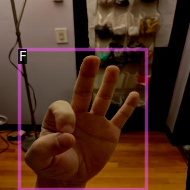

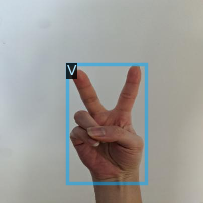

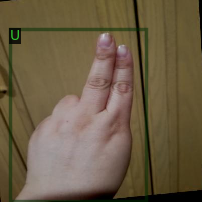

In [9]:
# DEBUGGING
# Check thing_classes not contains "Letters"
meta = MetadataCatalog.get(TRAIN_DATASET)
print(meta.thing_classes)  # Should be A–Z, no "Letters"

# Check category IDs indexing starts at 0 in the loaded dicts
dataset = DatasetCatalog.get(TRAIN_DATASET)
print(set(ann["category_id"] for d in dataset for ann in d["annotations"]))  # Should be 0–25

# take a look at classified training data
for datapt in random.sample(DatasetCatalog.get(TRAIN_DATASET), 3): # test visibility
    img = cv2.imread(datapt["file_name"])
    visualizer = Visualizer(img[:, :, ::-1], metadata=meta, scale=0.5)
    out = visualizer.draw_dataset_dict(datapt)
    cv2_imshow(out.get_image()[:, :, ::-1])

In [13]:
cfg = get_cfg()

# load resnet50 config from Detectron2's set of models
cfg.merge_from_file(model_zoo.get_config_file(RESNET_MODEL))

# start with a pre-trained COCO object detection model
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url(RESNET_MODEL)

# name datasets
cfg.DATASETS.TRAIN = (TRAIN_DATASET,)
cfg.DATASETS.TEST = (VALID_DATASET,)

# number of classes: 26 (A-Z)
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 26

# number of iterations
cfg.SOLVER.MAX_ITER = ITERS

cfg.SOLVER.BASE_LR = L_RATE   # learning rate

# init LR DECAY
cfg.SOLVER.GAMMA = DECAY_MULT
cfg.SOLVER.STEPS = DECAY_POINTS

cfg.SOLVER.IMS_PER_BATCH = 32
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 128

# set threshold for inference
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5

# For reproducibility
cfg.SEED = 42

# set output directory
cfg.OUTPUT_DIR = "/content/output"
os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)

# document config for later reference
os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
with open(os.path.join(cfg.OUTPUT_DIR, "config.yaml"), "w") as f:
    f.write(cfg.dump())

In [14]:
# create trainer instance, and train!!
trainer = DefaultTrainer(cfg)
trainer.resume_or_load(resume=False)
# if AUGMENT_DATA:
#       trainer.build_train_loader = lambda: build_detection_train_loader(cfg, mapper=custom_mapper)
trainer.train()

[07/24 06:40:40 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

roi_heads.box_predictor.bbox_pred.{bias, weight}
roi_heads.box_predictor.cls_score.{bias, weight}


[07/24 06:40:41 d2.engine.train_loop]: Starting training from iteration 0
[07/24 06:40:59 d2.utils.events]:  eta: 0:07:17  iter: 19  total_loss: 3.687  loss_cls: 3.11  loss_box_reg: 0.5805  loss_rpn_cls: 0.01127  loss_rpn_loc: 0.006968    time: 0.9125  last_time: 0.9124  data_time: 0.1541  last_data_time: 0.1403   lr: 9.7405e-05  max_mem: 19479M
[07/24 06:41:18 d2.utils.events]:  eta: 0:07:00  iter: 39  total_loss: 1.561  loss_cls: 0.9252  loss_box_reg: 0.5939  loss_rpn_cls: 0.01146  loss_rpn_loc: 0.007215    time: 0.9148  last_time: 0.9134  data_time: 0.1508  last_data_time: 0.1491   lr: 0.00019731  max_mem: 19479M
[07/24 06:41:36 d2.utils.events]:  eta: 0:06:41  iter: 59  total_loss: 1.357  loss_cls: 0.6903  loss_box_reg: 0.649  loss_rpn_cls: 0.004246  loss_rpn_loc: 0.005203    time: 0.9135  last_time: 0.9005  data_time: 0.1425  last_data_time: 0.1352   lr: 0.0002972  max_mem: 19479M
[07/24 06:41:54 d2.utils.events]:  eta: 0:06:23  iter: 79  total_loss: 1.341  loss_cls: 0.664  loss_b

In [15]:
# configure validation step

cfg_path = "/content/output/config.yaml"  # <- This is saved automatically during training ### IS THIS IN ENV VAR SOMEWHERE??

cfg.merge_from_file(cfg_path)
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")  # path to the model we just trained
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5   # set a low testing threshold to start

predictor = DefaultPredictor(cfg)

[07/24 06:48:33 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from /content/output/model_final.pth ...


In [16]:
setup_logger()

def measure_inference_speed(predictor, image_dir, max_images=100):
    image_files = [f for f in os.listdir(image_dir) if f.endswith(('.png', '.jpg', '.jpeg'))]
    image_files = image_files[:max_images]  # Limit number for consistent benchmarking

    total_time = 0
    times = []

    for fname in image_files:
        img_path = os.path.join(image_dir, fname)
        image = cv2.imread(img_path)

        start = time.time()
        outputs = predictor(image)
        end = time.time()

        elapsed = end - start
        times.append(elapsed)
        total_time += elapsed

    avg_time = total_time / len(times)
    fps = 1 / avg_time

    print(f"Tested {len(times)} images")
    print(f"Average inference time per image: {avg_time * 1000:.2f} ms")
    print(f"Approximate FPS: {fps:.2f}")
    return avg_time, fps

measure_inference_speed(predictor, "/content/drive/MyDrive/ColabNotebooks/resnet/ASL-COCO-JSON/valid")

Tested 100 images
Average inference time per image: 40.51 ms
Approximate FPS: 24.69


(0.04050518989562988, 24.688194341927783)

[07/24 06:48:38 d2.data.datasets.coco]: Loaded 144 images in COCO format from /content/drive/MyDrive/ColabNotebooks/resnet/ASL-COCO-JSON/valid/_annotations.coco.json
[07/24 06:48:38 d2.data.datasets.coco]: Loaded 1512 images in COCO format from /content/drive/MyDrive/ColabNotebooks/resnet/ASL-COCO-JSON/train/_annotations.coco.json
Test validation data:


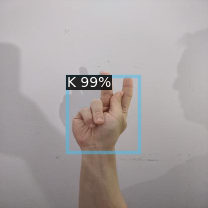

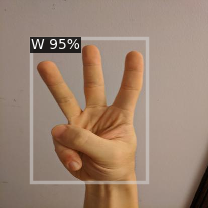

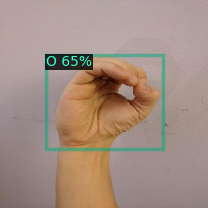

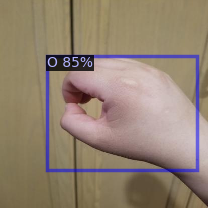

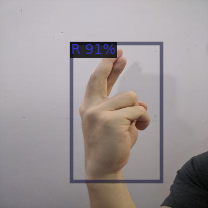

In [17]:
# Make predictions on new data
dataset_dicts_v = DatasetCatalog.get(VALID_DATASET)
metadata_v = MetadataCatalog.get(VALID_DATASET)

dataset_dicts_t = DatasetCatalog.get(TRAIN_DATASET)
metadata_t = MetadataCatalog.get(TRAIN_DATASET)

def test_random_images(dataset_dicts, metadata):
  for d in random.sample(dataset_dicts, 5):
      im = cv2.imread(d["file_name"])
      outputs = predictor(im)
      v = Visualizer(im[:, :, ::-1],
                    metadata=metadata,
                    scale=0.5,
      )
      out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
      cv2_imshow(out.get_image()[:, :, ::-1])

print("Test validation data:")
test_random_images(dataset_dicts_v, metadata_v)

[07/24 06:48:39 d2.data.datasets.coco]: Loaded 144 images in COCO format from /content/drive/MyDrive/ColabNotebooks/resnet/ASL-COCO-JSON/valid/_annotations.coco.json
[07/24 06:48:39 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[07/24 06:48:39 d2.data.common]: Serializing the dataset using: <class 'detectron2.data.common._TorchSerializedList'>
[07/24 06:48:39 d2.data.common]: Serializing 144 elements to byte tensors and concatenating them all ...
[07/24 06:48:39 d2.data.common]: Serialized dataset takes 0.04 MiB
[07/24 06:48:39 d2.data.datasets.coco]: Loaded 144 images in COCO format from /content/drive/MyDrive/ColabNotebooks/resnet/ASL-COCO-JSON/valid/_annotations.coco.json


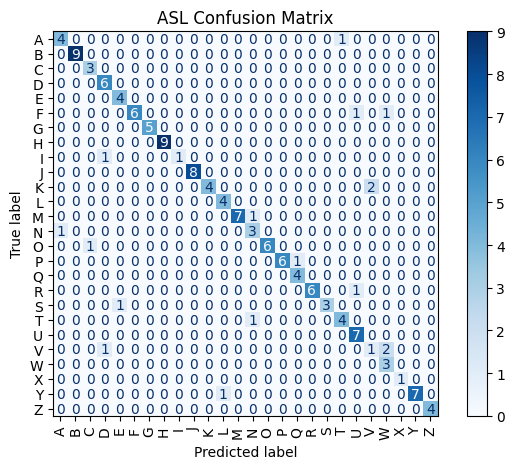

In [18]:
# Build Confusion Matrix
def collect_preds_and_labels(cfg, model, dataset_name):
    from detectron2.data import DatasetCatalog, build_detection_test_loader
    from detectron2.utils.logger import setup_logger
    import torch

    model.eval()
    loader = build_detection_test_loader(cfg, dataset_name)
    dataset_dicts = DatasetCatalog.get(dataset_name)

    gts = []
    preds = []

    for data, inputs in zip(dataset_dicts, loader):
        # Get GT class (assuming one per image)
        gt_class = data["annotations"][0]["category_id"]
        gts.append(gt_class)

        with torch.no_grad():
            outputs = model(inputs)[0]["instances"]
            scores = outputs.scores.cpu().numpy() if outputs.has("scores") else []
            pred_classes = outputs.pred_classes.cpu().numpy() if outputs.has("pred_classes") else []

            if len(scores) > 0:
                # Get highest-confidence prediction above threshold
                best_idx = scores.argmax()
                if scores[best_idx] > cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST:
                    preds.append(pred_classes[best_idx])
                else:
                    preds.append(-1)  # -1 means no confident prediction
            else:
                preds.append(-1)

    return np.array(gts), np.array(preds)



def plot_confusion_matrix(gt, pred, class_names):
    cm = confusion_matrix(gt, pred, labels=range(len(class_names)))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
    disp.plot(xticks_rotation=90, cmap="Blues")
    plt.title("ASL Confusion Matrix")
    plt.tight_layout()
    plt.show()

gt, pred = collect_preds_and_labels(cfg, trainer.model, VALID_DATASET)
plot_confusion_matrix(gt, pred, MetadataCatalog.get(VALID_DATASET).thing_classes)

In [19]:
# Model Evaluation
log_output = io.StringIO()

with contextlib.redirect_stdout(log_output):
  evaluator = COCOEvaluator(VALID_DATASET, cfg, False, output_dir=cfg.OUTPUT_DIR)
  val_loader = build_detection_test_loader(cfg, VALID_DATASET)
  results = inference_on_dataset(trainer.model, val_loader, evaluator)

print("mAP:", results["bbox"]["AP"])

log_contents = log_output.getvalue()

# Search for the AR value printed to stdout
match = re.search(r'Average Recall\s+\(AR\).*maxDets=100\s*\] = ([0-9.]+)', log_contents)
if match:
    AR = float(match.group(1))
else:
    raise ValueError("Could not find AR in log output")

# Use the actual AP from results
AP = results["bbox"]["AP"]

# Compute F1
F1 = 2 * (AP * AR) / (AP + AR) if (AP + AR) > 0 else 0
print(f"F1 Score (approximate): {F1:.3f}")

[07/24 06:48:44 d2.evaluation.coco_evaluation]: Fast COCO eval is not built. Falling back to official COCO eval.
WARNING [07/24 06:48:44 d2.evaluation.coco_evaluation]: COCO Evaluator instantiated using config, this is deprecated behavior. Please pass in explicit arguments instead.
[07/24 06:48:44 d2.evaluation.coco_evaluation]: Trying to convert 'asl_valid' to COCO format ...
[07/24 06:48:44 d2.data.datasets.coco]: Converting annotations of dataset 'asl_valid' to COCO format ...)
[07/24 06:48:44 d2.data.datasets.coco]: Loaded 144 images in COCO format from /content/drive/MyDrive/ColabNotebooks/resnet/ASL-COCO-JSON/valid/_annotations.coco.json
[07/24 06:48:44 d2.data.datasets.coco]: Converting dataset dicts into COCO format
[07/24 06:48:44 d2.data.datasets.coco]: Conversion finished, #images: 144, #annotations: 144
[07/24 06:48:44 d2.data.datasets.coco]: Caching COCO format annotations at '/content/output/asl_valid_coco_format.json' ...
[07/24 06:48:44 d2.data.datasets.coco]: Loaded 14

In [20]:
# ### GET THIS WORKING TO REINFORCE CONFUSED/WEAK AREAS

# from albumentations import OneOf, ShiftScaleRotate, RandomBrightnessContrast, Blur

# weak_classes = ["N", "K", "P", "H"]
# augmentation = OneOf([
#     ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.1, rotate_limit=10, p=0.7),
#     RandomBrightnessContrast(p=0.3),
#     Blur(blur_limit=3, p=0.2),
# ], p=1.0)

# import random
# import cv2
# import torch
# import matplotlib.pyplot as plt
# from detectron2.data import MetadataCatalog, DatasetCatalog, detection_utils as utils
# from detectron2.data import transforms as T
# from detectron2.utils.visualizer import Visualizer

# ###

# # Define the same augmentations you'll use in training
# augmentations = T.AugmentationList([
#     T.ResizeShortestEdge(short_edge_length=(640, 800), max_size=1333, sample_style="choice"),
#     T.RandomFlip(horizontal=True),
#     T.RandomBrightness(0.8, 1.2),
#     T.RandomContrast(0.8, 1.2),
#     T.RandomRotation(angle=[-10, 10]),
# ])

# # Pick a random image from your registered training set
# dataset_dicts = DatasetCatalog.get(TRAIN_DATASET)
# metadata = MetadataCatalog.get(TRAIN_DATASET)
# sample = random.choice(dataset_dicts)

# # Load and augment image
# image = utils.read_image(sample["file_name"], format="BGR")
# aug_image, transforms = T.apply_augmentations(augmentations.augs, image)
# annos = [utils.transform_instance_annotations(obj, transforms, aug_image.shape[:2])
#          for obj in sample["annotations"]]

# # Visualize original vs. augmented
# def show_image(img, title="Image"):
#     img_rgb = img[:, :, ::-1]  # BGR to RGB
#     plt.imshow(img_rgb)
#     plt.title(title)
#     plt.axis("off")

# # Visualize Augmentations
# v1 = Visualizer(image[:, :, ::-1], metadata=metadata, scale=0.7)
# v2 = Visualizer(aug_image[:, :, ::-1], metadata=metadata, scale=0.7)

# fig, ax = plt.subplots(1, 2, figsize=(16, 6))
# ax[0].imshow(v1.draw_dataset_dict(sample).get_image())
# ax[0].set_title("Original Image")
# ax[0].axis("off")
# ax[1].imshow(v2.draw_dataset_dict({"annotations": annos, "file_name": sample["file_name"]}).get_image())
# ax[1].set_title("Augmented Image")
# ax[1].axis("off")
# plt.show()


In [21]:
# import os, random, json, shutil
# from pathlib import Path
# import matplotlib.pyplot as plt
# from detectron2.config import get_cfg
# from detectron2.engine import DefaultTrainer, DefaultPredictor, HookBase
# from detectron2.engine import default_setup, launch
# from detectron2.data import DatasetCatalog, MetadataCatalog
# from detectron2.data.datasets import register_coco_instances
# from detectron2.evaluation import COCOEvaluator, inference_on_dataset
# from detectron2.data import build_detection_test_loader
# from detectron2.utils.events import get_event_storage

# # === CONFIG ===
# output_dir_base = "/content/learning_curve_runs"

# train_sizes = [100, 200, 500, 1000, 1512]
# repeats = 2

# # === Register validation set only once
# if VALID_DATASET not in DatasetCatalog.list():
#     register_coco_instances(VALID_DATASET, {}, VALID_JSON, VALID_IMGS)

# # === Helper: sample, save JSON + copy image files ===
# def sample_coco_dataset(original_json, image_dir, m, run_id):
#     with open(original_json) as f:
#         coco = json.load(f)

#     sampled_images = random.sample(coco["images"], m)
#     sampled_ids = {img["id"] for img in sampled_images}
#     sampled_annotations = [ann for ann in coco["annotations"] if ann["image_id"] in sampled_ids]

#     output_dir = f"{output_dir_base}/subset_{m}_{run_id}"
#     os.makedirs(output_dir, exist_ok=True)
#     subset_json_path = os.path.join(output_dir, "train_subset.json")
#     subset_img_dir = os.path.join(output_dir, "images")
#     os.makedirs(subset_img_dir, exist_ok=True)

#     for img in sampled_images:
#         shutil.copy(os.path.join(image_dir, img["file_name"]), os.path.join(subset_img_dir, img["file_name"]))

#     with open(subset_json_path, "w") as f:
#         json.dump({
#             "info": coco.get("info", {}),
#             "images": sampled_images,
#             "annotations": sampled_annotations,
#             "categories": coco["categories"]
#         }, f)

#     return subset_json_path, subset_img_dir

# # === Helper: train and evaluate model ===
# def train_and_evaluate(train_json, train_img_dir, train_size_name, run_id):
#     dataset_name = f"train_{train_size_name}_{run_id}"
#     if dataset_name not in DatasetCatalog.list():
#         register_coco_instances(dataset_name, {}, train_json, train_img_dir)

#     cfg = get_cfg()
#     cfg.merge_from_file(model_zoo.get_config_file(RESNET_MODEL))
#     cfg.DATASETS.TRAIN = (dataset_name,)
#     cfg.DATASETS.TEST = ('asl_valid',)
#     cfg.DATALOADER.NUM_WORKERS = 2
#     cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url(RESNET_MODEL)
#     cfg.SOLVER.IMS_PER_BATCH = 2
#     cfg.SOLVER.BASE_LR = L_RATE
#     cfg.SOLVER.MAX_ITER = ITERS
#     cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = IMG_BATCH_SIZE
#     cfg.MODEL.ROI_HEADS.NUM_CLASSES = 26
#     cfg.OUTPUT_DIR = os.path.join(output_dir_base, f"output_{train_size_name}_{run_id}")
#     os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)

#     trainer = DefaultTrainer(cfg)
#     trainer.resume_or_load(resume=False)
#     if AUGMENT_DATA:
#       trainer.build_train_loader = lambda: build_detection_train_loader(cfg, mapper=custom_mapper)
#     trainer.train()

#     # Evaluate on training subset
#     cfg.DATASETS.TEST = (dataset_name,)
#     evaluator_train = COCOEvaluator(dataset_name, cfg, False, output_dir=cfg.OUTPUT_DIR)
#     val_loader_train = build_detection_test_loader(cfg, dataset_name)
#     train_results = inference_on_dataset(trainer.model, val_loader_train, evaluator_train)

#     # Evaluate on full validation set
#     cfg.DATASETS.TEST = (VALID_DATASET,)
#     evaluator_val = COCOEvaluator(VALID_DATASET, cfg, False, output_dir=cfg.OUTPUT_DIR)
#     val_loader_val = build_detection_test_loader(cfg, VALID_DATASET)
#     val_results = inference_on_dataset(trainer.model, val_loader_val, evaluator_val)

#     train_ap = train_results['bbox']['AP']
#     val_ap = val_results['bbox']['AP']
#     return 100 - train_ap, 100 - val_ap

# # === Run learning curve experiment ===
# curve_data = []
# for size in train_sizes:
#     train_errors, val_errors = [], []
#     for run in range(repeats):
#         print(f"\n🚀 Training with {size} samples (Run {run+1}/{repeats})...")
#         sampled_json, sampled_img_dir = sample_coco_dataset(TRAIN_JSON, TRAIN_IMGS, size, run)
#         train_error, val_error = train_and_evaluate(sampled_json, sampled_img_dir, size, run)
#         train_errors.append(train_error)
#         val_errors.append(val_error)
#     curve_data.append({
#         "train_size": size,
#         "train_error": sum(train_errors) / len(train_errors),
#         "val_error": sum(val_errors) / len(val_errors)
#     })

# # === Plot Learning Curves ===
# train_sizes = [d["train_size"] for d in curve_data]
# train_errs = [d["train_error"] for d in curve_data]
# val_errs = [d["val_error"] for d in curve_data]

# plt.figure(figsize=(8,6))
# plt.plot(train_sizes, train_errs, marker='o', label="Training Error")
# plt.plot(train_sizes, val_errs, marker='o', label="Validation Error")
# plt.xlabel("Training Set Size")
# plt.ylabel("Error (100 - AP)")
# plt.title("Learning Curves")
# plt.legend()
# plt.grid(True)
# plt.tight_layout()
# plt.show()